In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt


In [5]:
#Read data
file_paths = [
    r"pop_mvmd.csv",
    r"propi.csv",
    r"ptax.csv",
    r"ratesav.csv",
    r"rcon.csv",
    r"rconhh_09Q3.csv",
    r"rcons.csv",
    r"rconsnp_09Q3.csv",
    r"rex.csv",
    r"rg.csv",
    r"rgf.csv",
    r"rgsl.csv",
    r"rimp.csv",
    r"rinvbf.csv",
    
    r"rinvrsid.csv",
    r"rnx.csv",
    r"ruc_md.csv",
    r"wsd.csv",
    r"cpi_md94Q3.csv",
    r"gdp.csv",
    r"hstarts_mvmd.csv",
    r"ipt_mvmd.csv",
    r"lfc_mvmd.csv",
    r"lfpart_mvmd.csv",
    r"m1_md.csv",
    r"oli.csv",
    r"oph.csv",
    r"oph_98Q4.csv",
    r"p.csv",
    r"pinti.csv",
    r"pintpaid.csv"
]
dataframes = ["rinvchi"]
for file_path in file_paths:
    try:
        # Extracting filename without extension
        file_name = file_path.split("\\")[-1].split(".")[0]
        # Reading CSV into DataFrame with variable name same as filename
        globals()[file_name] = pd.read_csv(file_path, encoding="utf-8")
        
        # Printing name and dimensions
        #print("Name:", file_name)
        #print("Dimensions:", globals()[file_name].shape)
        dataframes.append(file_name)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

rinvchi = pd.read_excel("rinvchiQvQd.xlsx")

In [7]:
monthly_dataframes = []

for file_name in dataframes:
    # Check if the number of rows in the DataFrame is greater than 308
    if len(globals()[file_name]) > 308:
        # Append the file name to the list
        monthly_dataframes.append(file_name)
def convert (df):
    quarterly_data = df[df['DATE'].str.endswith(('03', '06', '09', '12'))].reset_index(drop=True)

    #print(quarterly_data.shape)
    return quarterly_data

for file_name in monthly_dataframes:
    globals()[file_name] = convert(globals()[file_name])

ipt_mvmd = ipt_mvmd.iloc[-308:].reset_index(drop=True)

Extract data col from each df according to forcast point 

In [8]:
def get_month_code(lookup):
    suffix = lookup[-2:]
    month_mapping = {
        "Q1": "M3",
        "Q2": "M6",
        "Q3": "M9",
        "Q4": "M12"
    }
    if suffix in month_mapping:
        return lookup[:2] + month_mapping[suffix]
    else:
        return None



def data_extract(lookup):
    result_df = pd.DataFrame() 
    gdp_columns = [col for col in gdp if col.endswith(lookup)]
    if gdp_columns:
        # Extract the column along with its header
        result_df = pd.concat([result_df, gdp["DATE"]], axis=1)
        #result_df = pd.concat([result_df, gdp[gdp_columns[0]]], axis=1)



    #other predictor
    for name in dataframes: 
        df= globals()[name]  
        df_q = [col for col in df if col.endswith(lookup)]
        if df_q:
            result_df = pd.concat([result_df, df[df_q[0]]], axis=1)
        else:
            mlook = get_month_code(lookup)
            df_q = [col for col in df if col.endswith(mlook)]
            if df_q:
             result_df = pd.concat([result_df, df[df_q[0]]], axis=1)
    return result_df


In [9]:
#Add lags
#use lagged observations (e.g. t-x to t-12) as input variables to forecast the current time step (t) , where x is the number of steps ahead
def series_to_supervised(data, col_name, n_in=1, steps = 1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list, NumPy array, or pandas DataFrame/Series.
    Col_name: name of column to transform
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1
    if isinstance(data, list) or isinstance(data, np.ndarray):
        n_vars = 1
    elif isinstance(data, pd.DataFrame):
        n_vars = data.shape[1]
    elif isinstance(data, pd.Series):
        n_vars = 1
        data = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported data type. Please provide data as a list, NumPy array, or pandas DataFrame/Series.")

    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, steps-1,-1):
        cols.append(df.shift(i))
        names += [(f'{col_name}(t-{i})')]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #agg.dropna(subset=[agg.columns[-1]], inplace=True)


    return agg

In [10]:
def add_na(data, name, n):
    if isinstance(data, pd.DataFrame):
        # Assuming you want to operate on the first column of the DataFrame
        yy = data.iloc[:, 0].dropna()
    elif isinstance(data, pd.Series):
        yy = data.dropna()
    else:
        raise ValueError("Input data must be a DataFrame or Series")

    # Reset the index of yy to ensure unique index values
    yy = yy.reset_index(drop=True)

    # Create a Series of NaN values with the same length as yy
    xx = pd.Series([np.nan] * n, index=range(len(yy)+1, len(yy) + n+1))
    # Set the name of the xx series to be the same as the original column name
    xx.name = name
    return pd.concat([yy, xx])


Train and Test Data

In [174]:

def random_forest (x1, x2,horizon,feature_importance, feature_name, n_tree = 50):
    lookup = x1[-2:] + x2
 

    df = data_extract(lookup)
    df = df[df.loc[:, df.columns.str.startswith('ROUTPUT')].notna().any(axis=1)]

    X_no_lag = df
    X_no_lag = X_no_lag.drop(columns=['DATE'])
    X_no_lag = X_no_lag.loc[:, ~X_no_lag.columns.duplicated()]


    y_no_lag = df.loc[:, df.columns.str.startswith('ROUTPUT')].iloc[:,0]


    # Drop NA rows at the bottom of X_no_lag
    #X_no_lag = X_no_lag.dropna(how='all', axis=0)
    # Drop NA rows at the bottom of y_no_lag
    #y_no_lag = y_no_lag.dropna(how='all')
    X_lag = pd.DataFrame()
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()

    X_cols = list(set(X_no_lag.columns.tolist()))

    for i in range(len(X_cols)):
        c = X_cols[i]
        try:
            col_na = add_na (X_no_lag[c],c, horizon)
            lagged_col = series_to_supervised(col_na, c, 12,horizon)
            X_lag = pd.concat([X_lag, lagged_col], axis=1)


        except Exception as e:
            print(f"Error occurred for column: {c}, Error: {e}")
            
    #X_lag = X_lag.dropna(how='all')

    y_train = y_no_lag [horizon:,]
    #X_train = X_lag.iloc[horizon:-horizon,]  
    X_train = X_lag.iloc[horizon:horizon+len(y_train) ,]    
    y_train = y_no_lag [horizon:,]
    X_test = X_lag.iloc[-horizon:,]
    #print("Dimensions of X_lag:", X_lag.shape)
    #print("Dimensions of X_train:", X_train.shape)
    #print("Dimensions of X_test:", X_test.shape)
    #print("Dimensions of y_train:", y_train.shape)

    rf_model = RandomForestRegressor(n_estimators= n_tree)
    rf_model.fit(X_train, y_train)
    
    
    print("-----")
    print(horizon)
    print(len(feature_importance)+1)
    
    if horizon < len(feature_importance)+1:
    # If it exists, add rf_model.feature_importances_ to the existing one
        feature_importance[horizon-1] += rf_model.feature_importances_
    else:
    # If it doesn't exist, append rf_model.feature_importances_ to the array
        feature_importance.append([rf_model.feature_importances_])
        feature_name.append(X_train.columns)
    predictions = rf_model.predict(X_test) 
    return predictions



In [223]:

#User inputs
input1 = '2010'
input2 = 'Q1'
input3 = '8Q'
#no of repetition
n_rep=3

In [224]:
feature_importance_scores = []
feature_names =[]

def rf (x1, x2, x3, rep):
    if not x3[1].isdigit():
        horizon = int(x3[0])
    else:
        horizon = int(x3[0:2])
    prediction_array = np.array([])
    
    for i in range(1, horizon+1):
        for j in range (rep):
            result = 0
            
            result = result + random_forest (x1, x2, i,feature_importance_scores, feature_names, n_tree = 25) [-1]
        
            #print(prediction_array)
        prediction_array= np.append(prediction_array, result)
        # Iterate over each element of the feature_importance list and divide by rep

    return prediction_array/rep

def get_feature ():
    return feature_importance_scores

def get_feature_names():
    return feature_names

In [225]:
v = rf(input1, input2,input3, n_rep)
v 

-----
1
1
-----
1
2
-----
1
2
-----
2
2
-----
2
3
-----
2
3
-----
3
3
-----
3
4
-----
3
4
-----
4
4
-----
4
5
-----
4
5
-----
5
5
-----
5
6
-----
5
6
-----
6
6
-----
6
7
-----
6
7
-----
7
7
-----
7
8
-----
7
8
-----
8
8
-----
8
9
-----
8
9


array([0.23842657, 0.29919568, 0.28490304, 0.21807002, 0.18387477,
       0.10291813, 0.24734529, 0.2213605 ])

In [226]:
def get_unique_feature_impt():
    dd = get_feature() 
    result = [[x_i / n_rep for x_i in x] for x in dd]
    impt = []
    for i in range (len(result)):
        sub_array = result[i][0]
        
        # Iterate over the sub_array
        sums = []
        for i in range(0, len(sub_array), 12):
            # Sum every 12 consecutive elements
            subset_sum = sum(sub_array[i:i+12])
            # Append the sum to the sums list
            sums.append(subset_sum)
        impt.append(sums)
    return impt


In [229]:
ggf=get_unique_feature_impt()
ggf

[[0.032072444733807666,
  0.08482334232622539,
  0.024734242768939152,
  0.026604270833564196,
  0.16618593254248246,
  0.024852556536190753,
  0.005342375495046642,
  0.018808241945413164,
  0.020851279270950717,
  0.013379868397399523,
  0.019371145160427556,
  0.019774652052883056,
  0.04254392663681428,
  0.01680492061314093,
  0.01237026725637233,
  0.012760792799232134,
  0.015058047212818636,
  0.013653046022543549,
  0.022814531338704695,
  0.01016589169435867,
  0.22104599888745466,
  0.023977026476151443,
  0.014393894035103697,
  0.01781027670187304,
  0.03187963982777226,
  0.012811640453546148,
  0.01874364745699921,
  0.015139853969939693,
  0.015663951185580435,
  0.025562295368263918],
 [0.03939166346718061,
  0.036291368724919774,
  0.050493511848017765,
  0.01866836427224717,
  0.15593982438292261,
  0.03583256270152991,
  0.024402479170991722,
  0.023807936211577587,
  0.030242309839792515,
  0.0366509084285858,
  0.01701379193112122,
  0.09964469951000211,
  0.01622

In [230]:
def get_unique_feature_names():
    index_list = get_feature_names()
    unique_modified_indices = []
    for i in range(len(index_list)):
        sub_list = index_list[i]


        modified_indices = []
        # Loop through the index list and extract the desired substring
        for j in range(len(sub_list)):
            index = sub_list[j]
            # Extract the substring before '(' 
            start_index = index.find('(')
            end_index = index.find(')')
            if start_index != -1 and end_index != -1:
                substring = index[0:start_index]
                modified_indices.append(substring)

        unique= list(set(modified_indices))
        unique_modified_indices.append(unique)
    # Display the modified indices
    return unique_modified_indices

In [233]:
dfg= get_unique_feature_names()
dfg[0]

['RIMP10Q1',
 'RCONS10Q1',
 'REX10Q1',
 'LFC10M3',
 'rinvresid10Q1',
 'PINTI10Q1',
 'RATESAV10Q1',
 'M110Q1',
 'CPI10Q1',
 'PTAX10Q1',
 'HSTARTS10M3',
 'rconhh10Q1',
 'RUC10Q1',
 'POP10M3',
 'RNX10Q1',
 'ROUTPUT10Q1',
 'RGF10Q1',
 'rinvbf10Q1',
 'OLI10Q1',
 'rinvchi10Q1',
 'IPT10M3',
 'WSD10Q1',
 'OPH10Q1',
 'LFPART10M3',
 'PROPI10Q1',
 'RG10Q1',
 'RGSL10Q1',
 'PINTPAID10Q1',
 'P10Q1',
 'rconsnp10Q1']

Single model for all horizon

In [35]:
def rf1 (x1, x2, x3):
    if not x3[1].isdigit():
        horizon = int(x3[0])
    else:
        horizon = int(x3[0:2])
    prediction_array  = np.zeros(horizon)
    
    for i in range(20):
     
        prediction_array = prediction_array + random_forest1 (x1, x2, horizon , n_tree = 100)
        #print(prediction_array)
    return prediction_array/20

In [34]:
def random_forest1 (x1, x2,horizon, n_tree = 100):
    lookup = x1[-2:] + x2
    step = horizon

    df = data_extract(lookup)
    df = df[df.loc[:, df.columns.str.startswith('ROUTPUT')].notna().any(axis=1)]

    X_no_lag = df
    X_no_lag = X_no_lag.drop(columns=['DATE'])
    X_no_lag = X_no_lag.loc[:, ~X_no_lag.columns.duplicated()]


    y_no_lag = df.loc[:, df.columns.str.startswith('ROUTPUT')].iloc[:,0]


    # Drop NA rows at the bottom of X_no_lag
    #X_no_lag = X_no_lag.dropna(how='all', axis=0)
    # Drop NA rows at the bottom of y_no_lag
    #y_no_lag = y_no_lag.dropna(how='all')
    X_lag = pd.DataFrame()
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()

    X_cols = list(set(X_no_lag.columns.tolist()))

    for i in range(len(X_cols)):
        c = X_cols[i]
        try:
            col_na = add_na (X_no_lag[c],c, horizon)
            lagged_col = series_to_supervised(col_na, c, 12,horizon)
            X_lag = pd.concat([X_lag, lagged_col], axis=1)


        except Exception as e:
            print(f"Error occurred for column: {c}, Error: {e}")
            
    #X_lag = X_lag.dropna(how='all')

    y_train = y_no_lag [horizon:,]
    #X_train = X_lag.iloc[horizon:-horizon,]  
    X_train = X_lag.iloc[horizon:horizon+len(y_train) ,]    
    y_train = y_no_lag [horizon:,]
    X_test = X_lag.iloc[-horizon:,]
    #print("Dimensions of X_lag:", X_lag.shape)
    #print("Dimensions of X_train:", X_train.shape)
    #print("Dimensions of X_test:", X_test.shape)
    #print("Dimensions of y_train:", y_train.shape)

    rf_model = RandomForestRegressor(n_estimators= n_tree)
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test) 
    return predictions


In [36]:
rf1(input1, input2,input3)

array([0.35646067, 0.57545753, 0.55719445, 0.4429708 , 0.47669233,
       0.40252278, 0.6326554 , 0.76048017])

Predicted Value

Feature Importance

In [24]:
f = get_feature()
mean_importance= np.mean(f,axis = 0)
feature_names1 = feature_names[0]

feature_names

[Index(['PROPI23Q1(t-12)', 'PROPI23Q1(t-11)', 'PROPI23Q1(t-10)',
        'PROPI23Q1(t-9)', 'PROPI23Q1(t-8)', 'RIMP23Q1(t-12)', 'RIMP23Q1(t-11)',
        'RIMP23Q1(t-10)', 'RIMP23Q1(t-9)', 'RIMP23Q1(t-8)',
        ...
        'PINTI23Q1(t-12)', 'PINTI23Q1(t-11)', 'PINTI23Q1(t-10)',
        'PINTI23Q1(t-9)', 'PINTI23Q1(t-8)', 'rconsnp23Q1(t-12)',
        'rconsnp23Q1(t-11)', 'rconsnp23Q1(t-10)', 'rconsnp23Q1(t-9)',
        'rconsnp23Q1(t-8)'],
       dtype='object', length=150),
 Index(['PROPI23Q1(t-12)', 'PROPI23Q1(t-11)', 'PROPI23Q1(t-10)',
        'PROPI23Q1(t-9)', 'PROPI23Q1(t-8)', 'RIMP23Q1(t-12)', 'RIMP23Q1(t-11)',
        'RIMP23Q1(t-10)', 'RIMP23Q1(t-9)', 'RIMP23Q1(t-8)',
        ...
        'PINTI23Q1(t-12)', 'PINTI23Q1(t-11)', 'PINTI23Q1(t-10)',
        'PINTI23Q1(t-9)', 'PINTI23Q1(t-8)', 'rconsnp23Q1(t-12)',
        'rconsnp23Q1(t-11)', 'rconsnp23Q1(t-10)', 'rconsnp23Q1(t-9)',
        'rconsnp23Q1(t-8)'],
       dtype='object', length=150),
 Index(['PROPI23Q1(t-12)', 'PROPI23Q

In [ ]:
sorted_indices = np.argsort(mean_importance)
sorted_importance = mean_importance[sorted_indices]
feature_names1 = feature_names[0]
sorted_feature_names = feature_names1[sorted_indices]

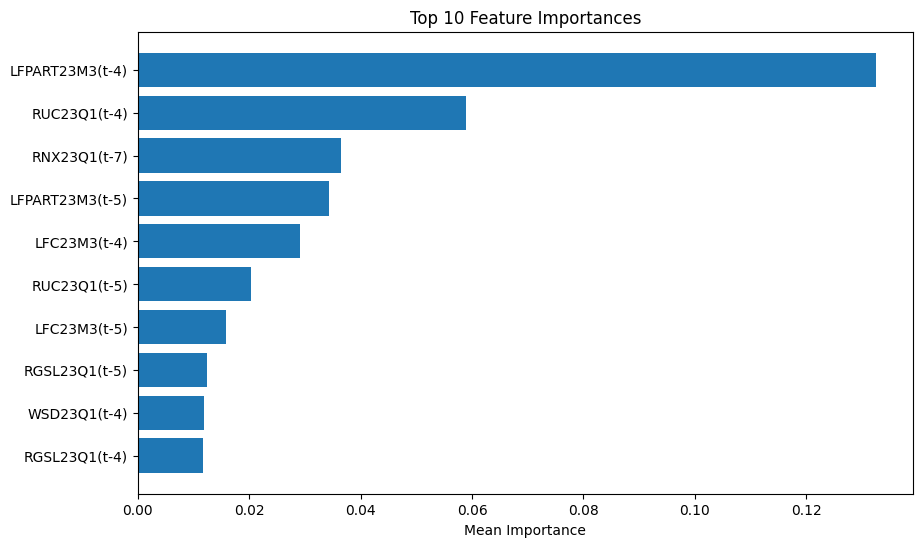

In [275]:
# Take the top 10 features
top_n = 10
top_importance = sorted_importance[-top_n:]
top_feature_names = sorted_feature_names[-top_n:]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(top_importance)), top_importance, align='center')
plt.yticks(np.arange(len(top_importance)), top_feature_names)
plt.xlabel('Mean Importance')
plt.title('Top 10 Feature Importances')
plt.show()

In [127]:
y_test = gdp['ROUTPUT24Q1'].iloc[-4:]
y_test

304    0.554621
305    0.510176
306    1.186611
307    0.806849
Name: ROUTPUT24Q1, dtype: float64

In [131]:
# Calculate the Mean Squared Error (MSE)

mse = mean_squared_error(y_test, v)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.5916330509133058


The importance of features in a machine learning model, such as a Random Forest, represents the contribution of each feature to the model's predictive performance. It indicates how much each feature influences the model's predictions. Feature importance is a valuable metric for understanding which features are most relevant or influential in making predictions.

In the context of a Random Forest model:

Feature Importance: 
The importance of a feature is typically calculated based on how much the feature reduces impurity in the decision trees within the Random Forest. Features that lead to the greatest decrease in impurity (e.g., Gini impurity or entropy) when used in splitting decisions are considered more important.

Relative Importance: 
Feature importance is usually relative rather than absolute. That means the importance of features is compared within the context of the specific model being trained. Features with higher importance values are relatively more important compared to features with lower values in the same model.

Interpretation: 
Higher feature importance suggests that the feature has a stronger relationship with the target variable and contributes more to the model's predictions. Conversely, lower feature importance indicates that the feature has less influence on the model's predictions.

Usage:
Feature selection: Identifying the most important features for model training and reducing the dimensionality of the dataset.
Model interpretation: Understanding the factors driving the model's predictions and gaining insights into the underlying relationships in the data.
Debugging: Identifying potential issues such as irrelevant or redundant features, data leakage, or biases in the training data.